<a href="https://colab.research.google.com/github/ABD-01/Face-Unlock/blob/master/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm #, tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

from typing import Callable, Optional
from  torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/datasets.py 
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/triplet_loss.py
!wget https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/eval.py

--2021-05-21 11:16:38--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9794 (9.6K) [text/plain]
Saving to: ‘model.py’

model.py            100%[===================>]   9.56K  --.-KB/s    in 0s      

2021-05-21 11:16:38 (99.6 MB/s) - ‘model.py’ saved [9794/9794]

--2021-05-21 11:16:38--  https://raw.githubusercontent.com/ABD-01/Face-Unlock/master/datasets.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1385 (1.4K) [text/plain]
Saving to: ‘datasets.py’

datas

In [3]:
import triplet_loss
from models import ResNet
from datasets import AttDataset, YaleDataset
from eval import *

In [4]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_init()
# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19


In [5]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
process = transforms.Compose([
    transforms.Resize((224,224), interpolation= transforms.InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])

In [7]:
train_data = AttDataset(PATH, transform=process)
train_data

Dataset AttDataset
    Number of datapoints: 400
    Root location: /content/drive/MyDrive/Colab Notebooks/att_face_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.4422, std=0.1931)
           )

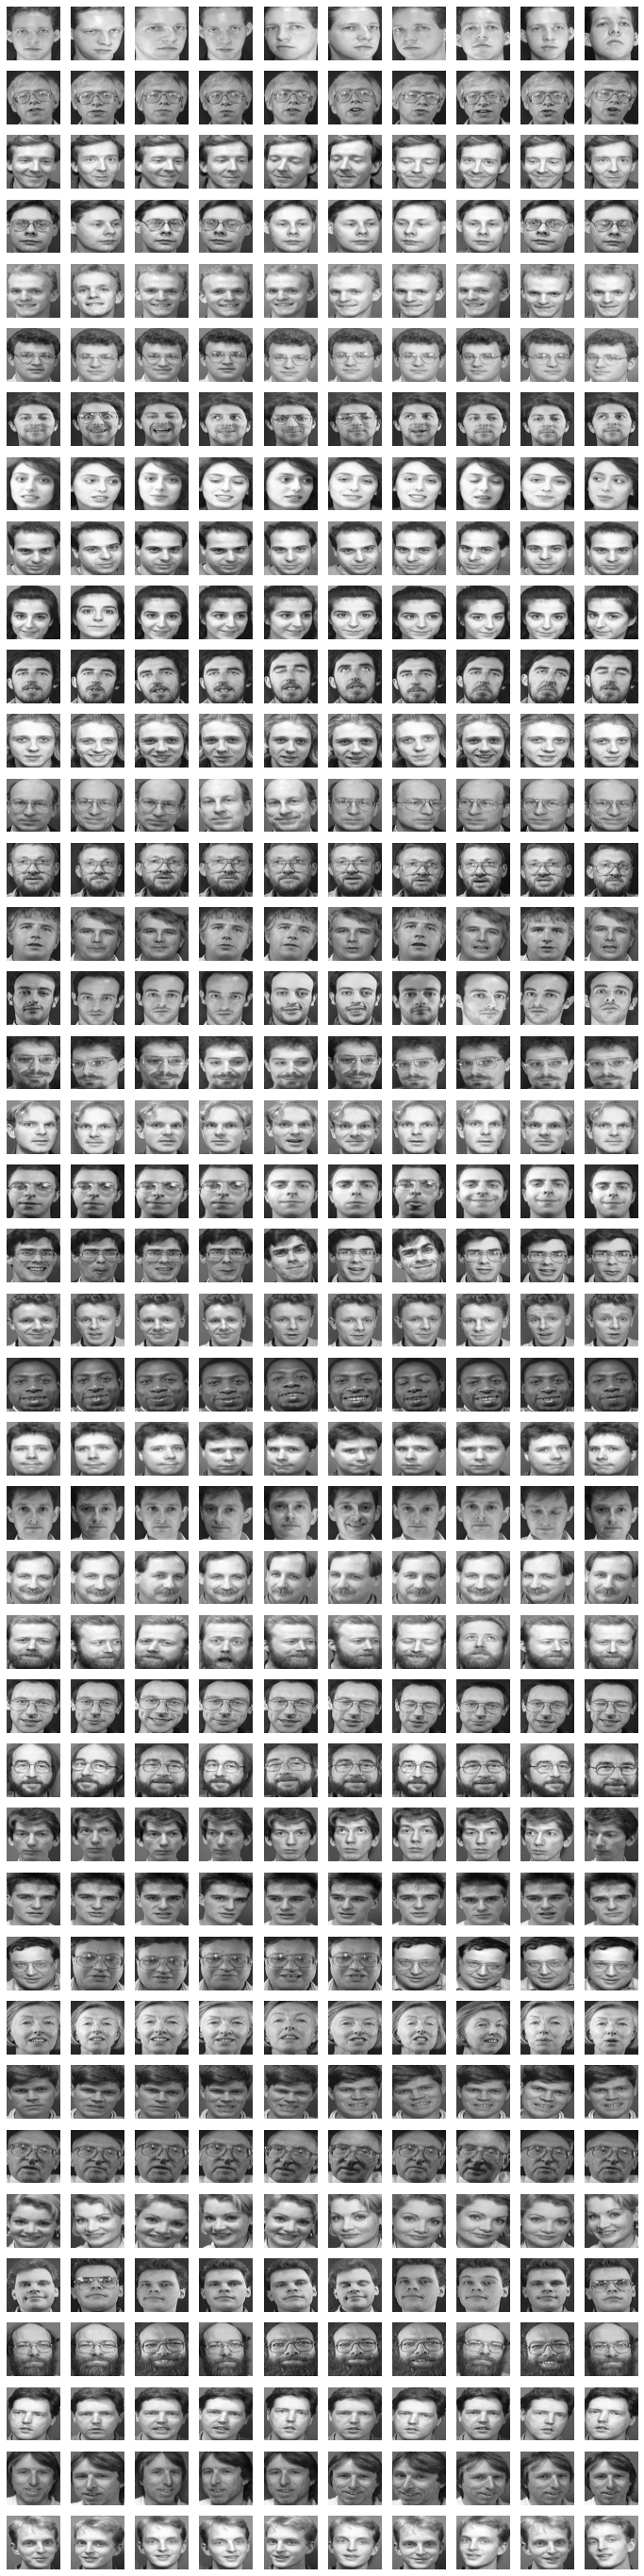

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,50))
for i, ax in enumerate(axxr.flatten()):
    ax.imshow(train[i][0].squeeze(), cmap="gray")
    ax.axis('off')
plt.axis('off')
plt.savefig("train_data.png", dpi=300)
plt.show()

In [ ]:
# Ref : http://vision.ucsd.edu/content/yale-face-database
'''
!wget http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
!unzip yalefaces.zip

import os, shutil, glob
for i in range(1,16):
    files = glob.glob(f'yalefaces/subject{i:02d}*')
    for f in files:
        des = f'yalefaces/subject{i:02d}'
        if not os.path.exists(des):
            os.makedirs(des)
        shutil.move(f, des)
'''

In [8]:
test = YaleDataset(
    path = "/content/drive/MyDrive/Colab Notebooks/yalefaces" ,
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.4422, std=0.1931)
    ])
)
test

Dataset YaleDataset
    Number of datapoints: 165
    Root location: /content/drive/MyDrive/Colab Notebooks/yalefaces
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.4422, std=0.1931)
           )

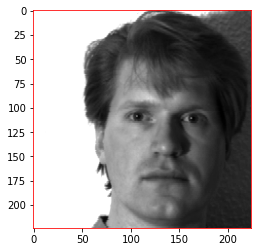

In [ ]:
ax = plt.subplot()
ax.imshow(test[3][0].squeeze(), cmap='gray')
for spine in ax.spines.values():
    spine.set_color("red")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

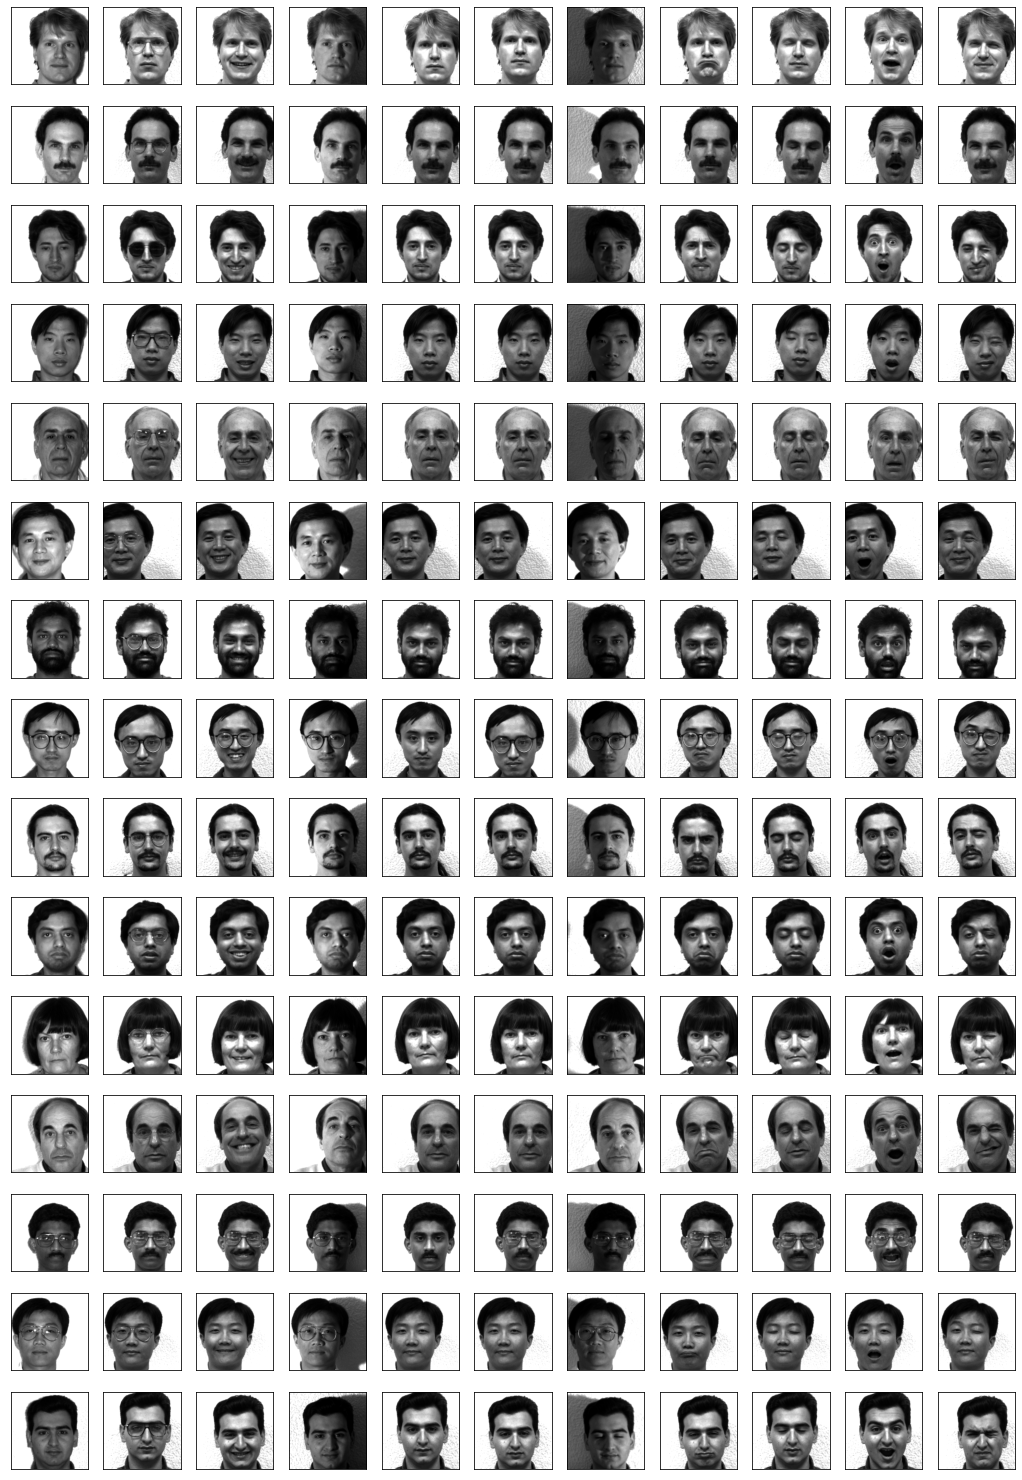

In [11]:
_,axxr = plt.subplots(15,11, figsize=(18,27))
for i, ax in enumerate(axxr.flatten()):
    ax.imshow(test[i][0].squeeze(), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('test_data.png', dpi=300)
plt.show()

In [9]:
!pip install wandb
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
import wandb
# 1. Start a new run
wandb.init(project="Face-Unlock")

wandb: Currently logged in as: abd1 (use `wandb login --relogin` to force relogin)


In [11]:
resnet18 = ResNet()
resnet18.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [ ]:
def Triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [24]:
# 2. Save model inputs and hyperparameters
config = wandb.config
config.epochs = 100
config.classes = 40
config.batch_size = 40
config.learning_rate = 0.05
config.train_dataset = "AttDataset"
config.test_dataset = "YaleDataset"
config.architechture = "ResNet18"

In [25]:
loader = torch.utils.data.DataLoader(train_data, batch_size = config.batch_size, shuffle=True)
optimizer18 = optim.Adam(resnet18.parameters(), lr = config.learning_rate)
# scheduler18 = optim.lr_scheduler.ReduceLROnPlateau(optimizer18, factor=0.5, patience=2, min_lr=0.00001, verbose=True)
torch_triplet_loss = nn.TripletMarginLoss()

In [19]:
image, label = next(iter(loader))
image.shape, label.shape

(torch.Size([40, 1, 224, 224]), torch.Size([40]))

In [26]:
wandb.watch(resnet18, criterion='all')

In [27]:
total_loss = []
epochs_loss =[]
for epoch in range(config.epochs):
    epoch_loss = 0
    for step, (images, labels) in enumerate(loader):
        print(f"Epoch: {epoch:02d}, Step: {step:02d},", end=" ")
        start_time = time.time()

        embds = resnet18(images.to(device)).to('cpu')

        loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
        epoch_loss += loss.item()
        wandb.log({"loss": loss.item(), "fraction_of_positive_triplets": fpt})
        print(f"Loss: {loss.item():.3f}, +ve triplets: {fpt:.2f},", end=" ")

        optimizer18.zero_grad()
        loss.backward()
        optimizer18.step()

        current_time = time.time()
        print("Time: {:.4f}s".format(current_time-start_time))
    wandb.log({"epoch_loss": epoch_loss/config.batch_size})
    epochs_loss.append(epoch_loss/config.batch_size)

Epoch: 00, Step: 00, Loss: 0.930, +ve triplets: 1.00, Time: 0.3523s
Epoch: 00, Step: 01, Loss: 0.969, +ve triplets: 1.00, Time: 0.3460s
Epoch: 00, Step: 02, Loss: 0.907, +ve triplets: 1.00, Time: 0.3600s
Epoch: 00, Step: 03, Loss: 0.668, +ve triplets: 1.00, Time: 0.3602s
Epoch: 00, Step: 04, Loss: 0.909, +ve triplets: 1.00, Time: 0.3320s
Epoch: 00, Step: 05, Loss: 0.708, +ve triplets: 1.00, Time: 0.3256s
Epoch: 00, Step: 06, Loss: 0.753, +ve triplets: 0.90, Time: 0.3598s
Epoch: 00, Step: 07, Loss: 0.736, +ve triplets: 0.92, Time: 0.3549s
Epoch: 00, Step: 08, Loss: 0.762, +ve triplets: 0.75, Time: 0.3361s
Epoch: 00, Step: 09, Loss: 0.947, +ve triplets: 0.66, Time: 0.3593s
Epoch: 01, Step: 00, Loss: 0.898, +ve triplets: 0.52, Time: 0.2402s
Epoch: 01, Step: 01, Loss: 1.029, +ve triplets: 0.57, Time: 0.2414s
Epoch: 01, Step: 02, Loss: 0.870, +ve triplets: 0.65, Time: 0.2409s
Epoch: 01, Step: 03, Loss: 1.035, +ve triplets: 0.77, Time: 0.2394s
Epoch: 01, Step: 04, Loss: 1.066, +ve triplets: 

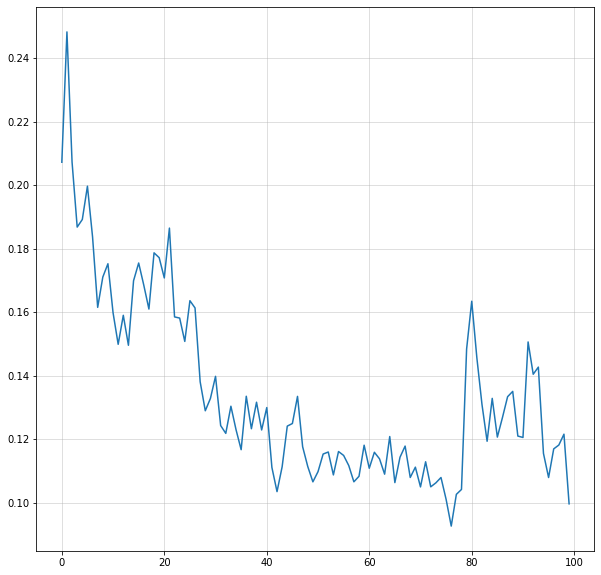

In [28]:
plt.figure(figsize=(10,10))
plt.plot(epochs_loss, label="EpochLoss")
plt.grid(alpha=0.5)

In [29]:
# torch.save(resnet18.state_dict(), "/content/drive/MyDrive/Colab Notebooks/facenet2.pth")

In [ ]:
resnet18 = ResNet()
resnet18.to(device)
resnet18.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/facenet1.pth", map_location=torch.device('cpu')))
# resnet18.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/facenet1.pth"))
resnet18.eval()

## Testing

In [ ]:
resnet18.eval()

In [31]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1).pow(.5)

tensor(3.2337, grad_fn=<PowBackward0>)


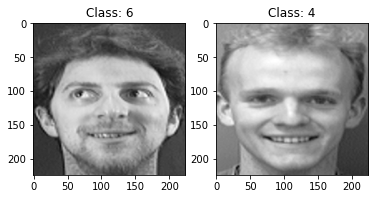

In [ ]:
_,(i1,i2) = plt.subplots(1,2)

img1 = train_data[63]#[0]
img2 = train_data[42]#[0]

i1.imshow(img1[0].squeeze(), cmap='gray')
i1.title.set_text(f'Class: {img1[1]}')
i2.imshow(img2[0].squeeze(), cmap='gray')
i2.title.set_text(f'Class: {img2[1]}')

embd = resnet18(torch.stack([img1[0],img2[0]]).to(device)).to('cpu')
print(dist(embd[0], embd[1]).pow(.5))

In [32]:
tl = torch.utils.data.DataLoader(train_data, batch_size = 400)

In [33]:
tl = next(iter(tl))

In [34]:
images, labels = tl
del tl
images.shape, labels.shape

(torch.Size([400, 1, 224, 224]), torch.Size([400]))

In [ ]:
def model(images):
    embeddings = resnet18(images.to(device)).cpu()
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

In [35]:
# resnet18.cpu()
embeddings = resnet18(images.cuda()).cpu()
embeddings.shape

torch.Size([400, 128])

In [36]:
from sklearn.manifold import TSNE

In [37]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(embeddings.detach().numpy())

In [38]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    label = label.astype(np.int8)

    fig = plt.figure(figsize=(60,60))
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 40.),
                 fontdict={'weight': 'heavy', 'size': 30})
    # plt.xticks([])
    # plt.yticks([])
    plt.grid()
    plt.title(title)
    return fig

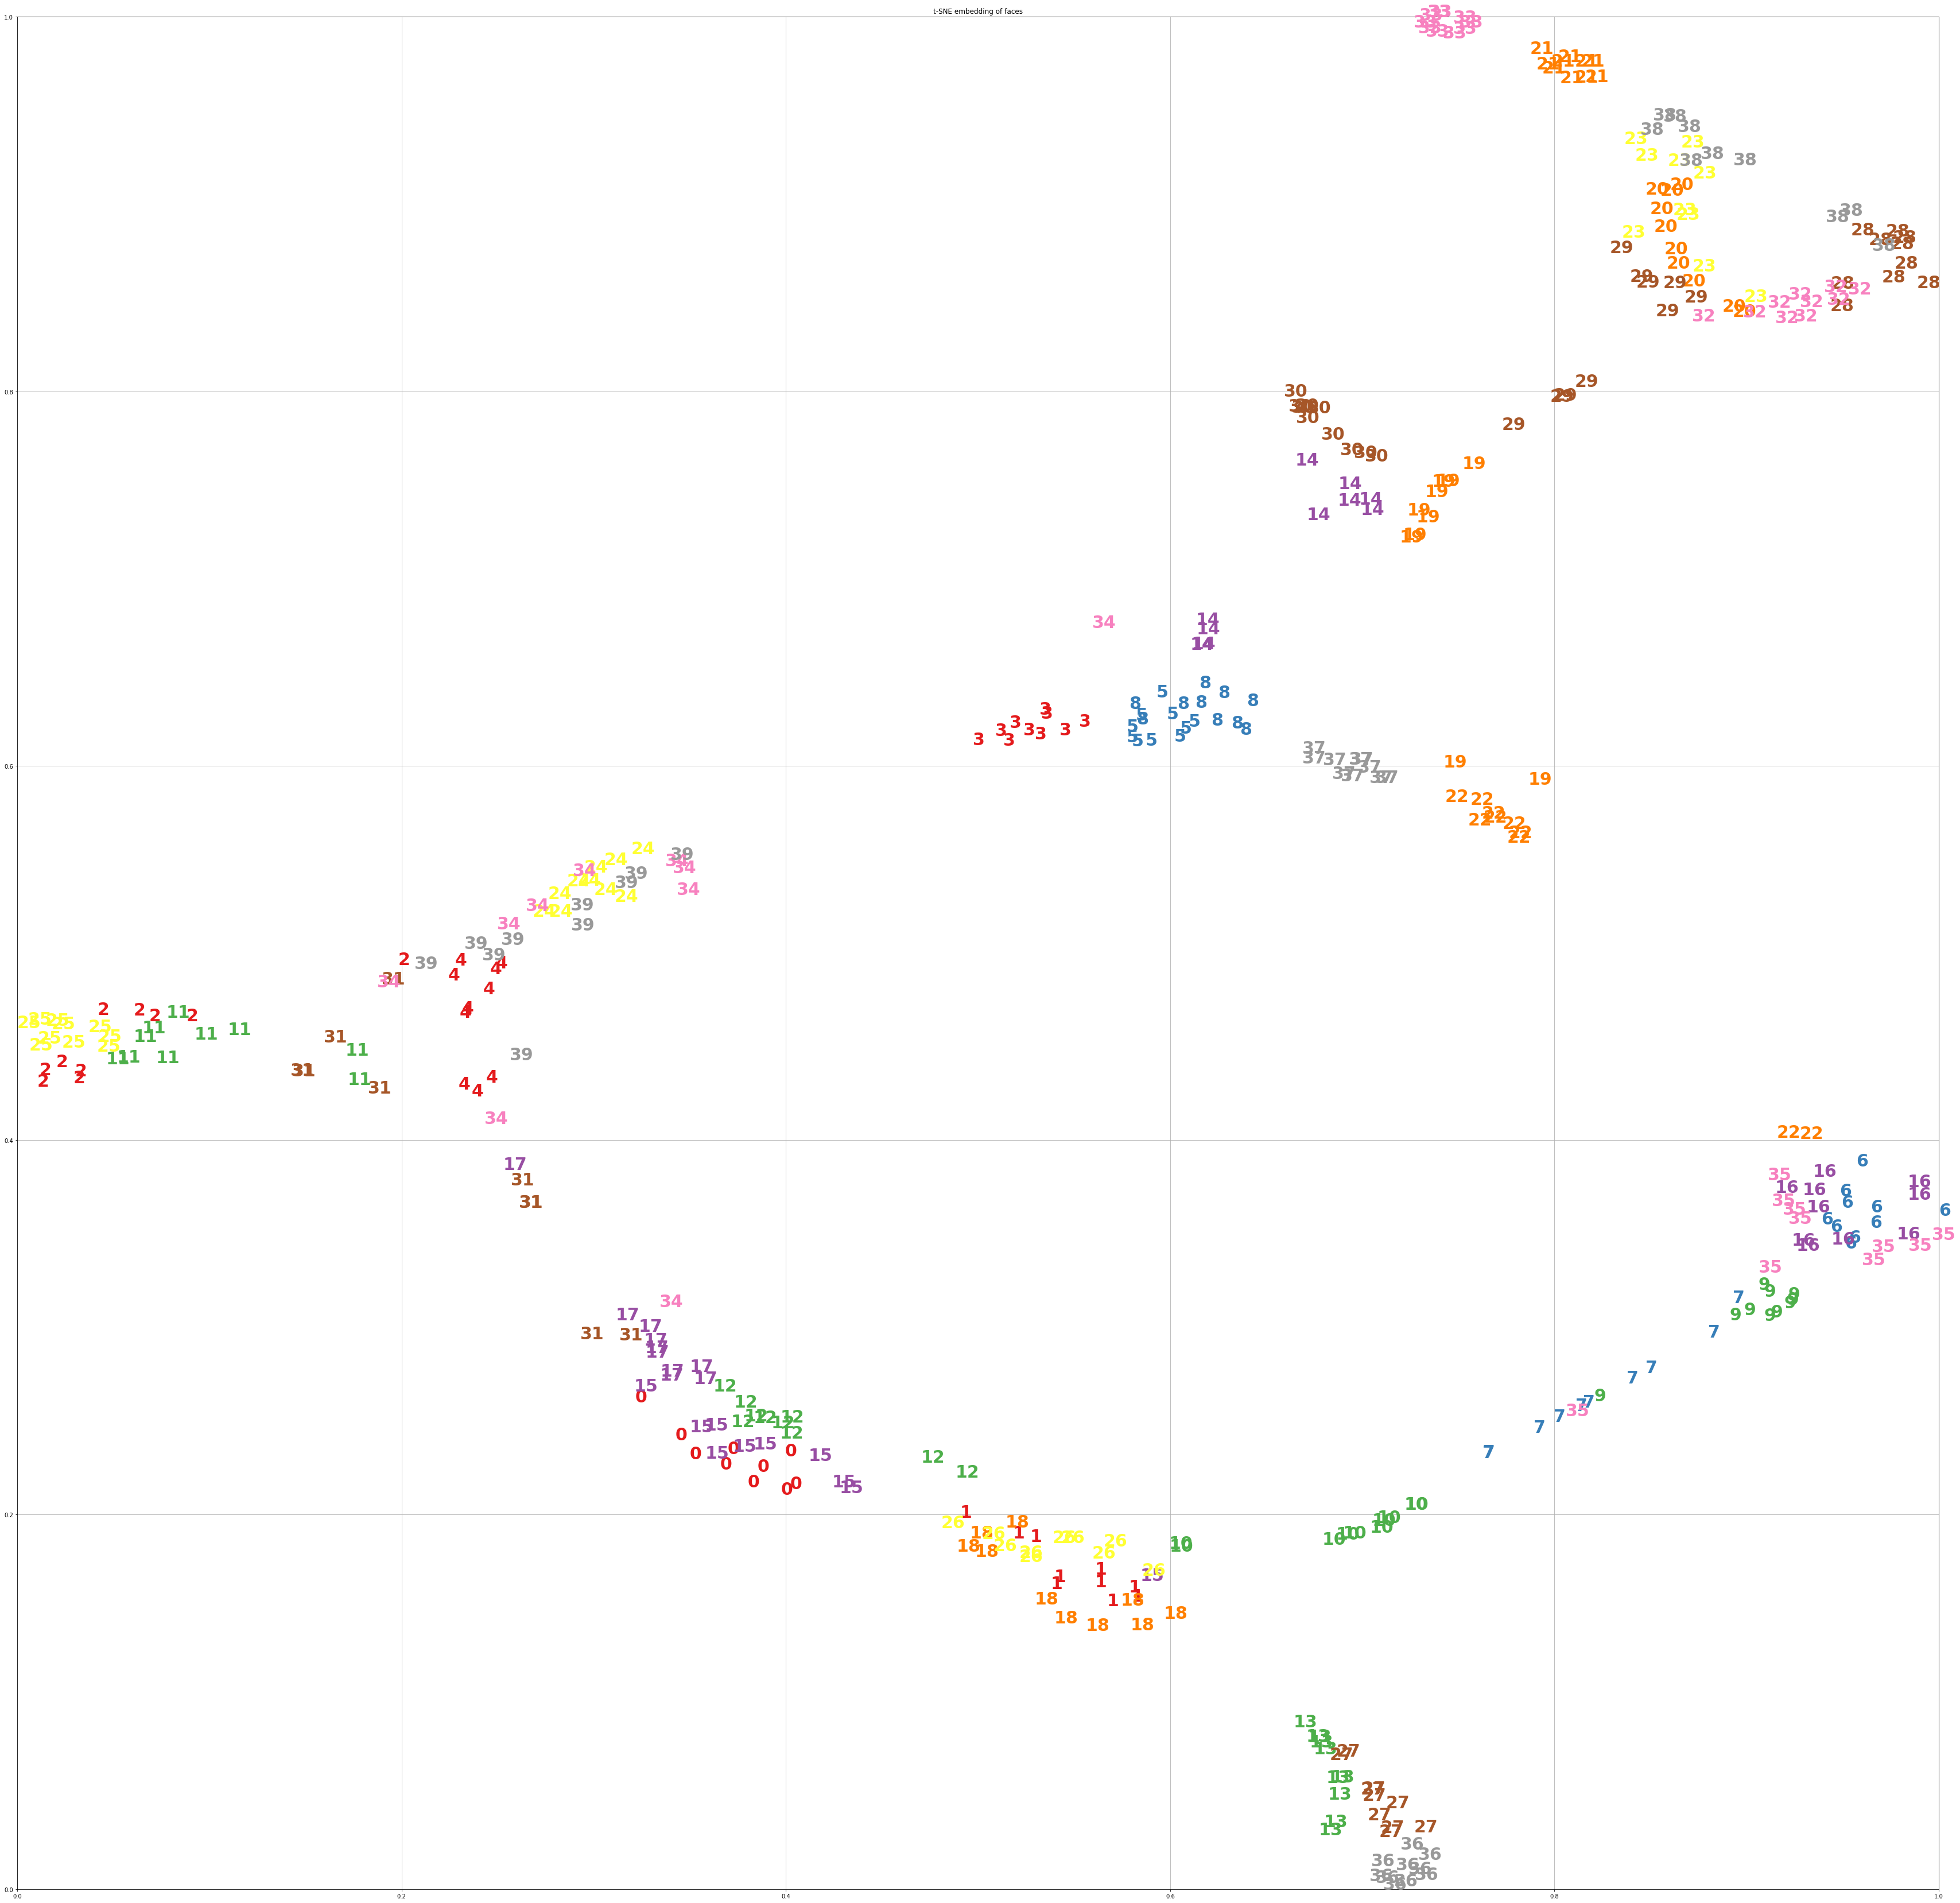

In [39]:
fig = plot_embedding(reduced, labels.detach().numpy(),'t-SNE embedding of faces')
# plt.savefig("t-SNE_visualization_of_embeddings.png")
plt.show(fig)

In [40]:
(embeddings[0] < 1e-16).nonzero().squeeze()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  34,  35,  36,  37,  38,  39,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  80,  82,  83,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 123, 125, 126, 127])

In [41]:
(embeddings[1] < 1e-16).nonzero().squeeze()

tensor([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  34,  35,  36,  37,  38,  39,  41,  42,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  80,  82,  83,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
        107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        123, 125, 126, 127])

In [ ]:
(embeddings[7] < 1e-16).nonzero().squeeze()

tensor([  0,   3,   4,   5,   7,  10,  13,  18,  22,  23,  29,  31,  32,  36,
         39,  40,  42,  47,  49,  50,  55,  60,  64,  65,  67,  68,  69,  73,
         74,  82,  84,  86,  89,  92,  98,  99, 103, 105, 106, 107, 110, 111,
        112, 113, 115, 116, 117, 121, 122, 124, 125, 126, 127])

In [48]:
distances = triplet_loss._pairwise_distances(embeddings)
distances.shape, distances.max()

(torch.Size([400, 400]), tensor(1.4142, grad_fn=<MaxBackward1>))

In [44]:
def pairs_mask(labels):
    induces_not_equal = torch.eye(labels.shape[0]).bool().logical_not()
    return induces_not_equal
mask = pairs_mask(labels)

In [45]:
Psame = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))[mask]
Psame.shape, Psame.sum()

(torch.Size([159600]), tensor(3600))

In [46]:
Pdiff = Psame.logical_not()
Pdiff.shape, Pdiff.sum()

(torch.Size([159600]), tensor(156000))

In [49]:
dists = distances[mask]
dists.shape, dists.max(), dists.mean(), dists.min()

(torch.Size([159600]),
 tensor(1.4142, grad_fn=<MaxBackward1>),
 tensor(1.1709, grad_fn=<MeanBackward0>),
 tensor(0.0023, grad_fn=<MinBackward1>))

In [58]:
calculate_metrics(0.5, dists.detach().numpy(), Psame.detach().numpy())

(0.8838888888888888,
 0.08726923076923077,
 0.1894498690164325,
 0.9120802005012532)

In [ ]:
true_accepts  = np.logical_and(preds, Psame)
false_accepts = np.logical_and(preds, Pdiff)
false_rejects = np.logical_and(torch.logical_not(preds), Psame)
true_rejects  = np.logical_and(torch.logical_not(preds), Pdiff)

true_accepts.sum(), false_accepts.sum(), false_rejects.sum(), true_rejects.sum()

(tensor(2272), tensor(2), tensor(1328), tensor(155998))

In [ ]:
VAL = true_accepts.sum()  / Psame.sum() # true acceptance rate (tar, tpr, sensitivity)
FAR = false_accepts.sum() / Pdiff.sum() # false acceptance rate (fpr)
FRR = false_rejects.sum() / Psame.sum() # false reject rate (fnr)
TRR = true_rejects.sum()  / Pdiff.sum() # true reject rate (tnr)

VAL, FAR, FRR, TRR

(tensor(0.6311), tensor(1.2821e-05), tensor(0.3689), tensor(1.0000))

In [53]:
vals = []
fars = []
frrs = []
trrs = []
precisions = []
gmeans = []
f1_scores = []
accuracies = []
youdens = []
x = np.arange(0, 4, 0.01)
for threshold in tqdm_notebook(x):
    val, far, precision, accuracy = calculate_metrics(threshold, dists.detach().numpy(), Psame.detach().numpy())
    youden = val - far

    vals.append(val)
    fars.append(far)
    precisions.append(precision)
    accuracies.append(accuracy)
    youdens.append(youden)

vals = np.asarray(vals)
fars = np.asarray(fars)
frrs = np.asarray(frrs)
trrs = np.asarray(trrs)
precisions = np.asarray(precisions)
gmeans = np.asarray(gmeans)
f1_scores = np.asarray(f1_scores)
youdens = np.asarray(youdens)

In [54]:
p = np.argmax(precisions)
a = np.argmax(accuracies)
y = np.argmax(youdens)

In [55]:
p,a,y

(1, 4, 71)

In [56]:
precisions[p], accuracies[a], youdens[y], x[y]

(0.9166666666666666, 0.9782456140350877, 0.8306324786324786, 0.71)

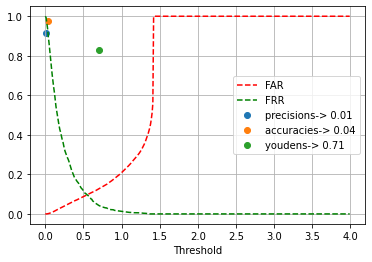

In [57]:
plt.figure()
plt.plot(x, fars, 'r--', label='FAR')
plt.plot(x, 1-vals, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.scatter(x[p], precisions[p], label=f'precisions-> {x[p]}')
plt.scatter(x[a], accuracies[a], label=f'accuracies-> {x[a]}')
plt.scatter(x[y], youdens[y], label=f'youdens-> {x[y]}')
plt.legend()
plt.grid()
plt.show()

400it [00:00, 813.11it/s]


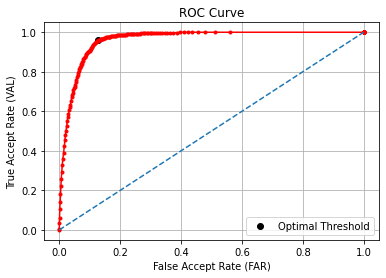

In [51]:
best_threshold, tar, far, precision, accuracy = evaluate(dists.detach().numpy(), Psame.detach().numpy(), roc_curve=True)

In [52]:
print("Best Threshold: {}\nTrue Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nAccuracy: {:.3f}".format(best_threshold, tar, far, precision, accuracy ))

Best Threshold: 0.71
True Acceptance: 0.959
False Acceptance: 0.128
Precision: 0.147
Accuracy: 0.874


# Test on test dataset

In [59]:
test_loader = DataLoader(test, batch_size=165)
len(test_loader)

1

In [60]:
del images, labels, distances, dists, embeddings

In [61]:
test = next(iter(test_loader))
images, labels = test
images.shape, labels.shape

(torch.Size([165, 1, 224, 224]), torch.Size([165]))

In [62]:
 images.mean(), images.std()

(tensor(0.7528), tensor(1.9500))

In [ ]:
# resnet18.cpu()
def model(images):
    embeddings = resnet18(images)
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

In [63]:
embeddings = resnet18(images.cuda()).cpu()
embeddings.shape

torch.Size([165, 128])

In [ ]:
from sklearn.manifold import TSNE

In [64]:
tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(embeddings.detach().numpy())

In [65]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    label = label.astype(np.int8)

    fig = plt.figure(figsize=(30,30))
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 15.),
                 fontdict={'weight': 'bold', 'size': 27})
    # plt.xticks([])
    # plt.yticks([])
    plt.grid(alpha=0.5)
    plt.title(title)
    return fig

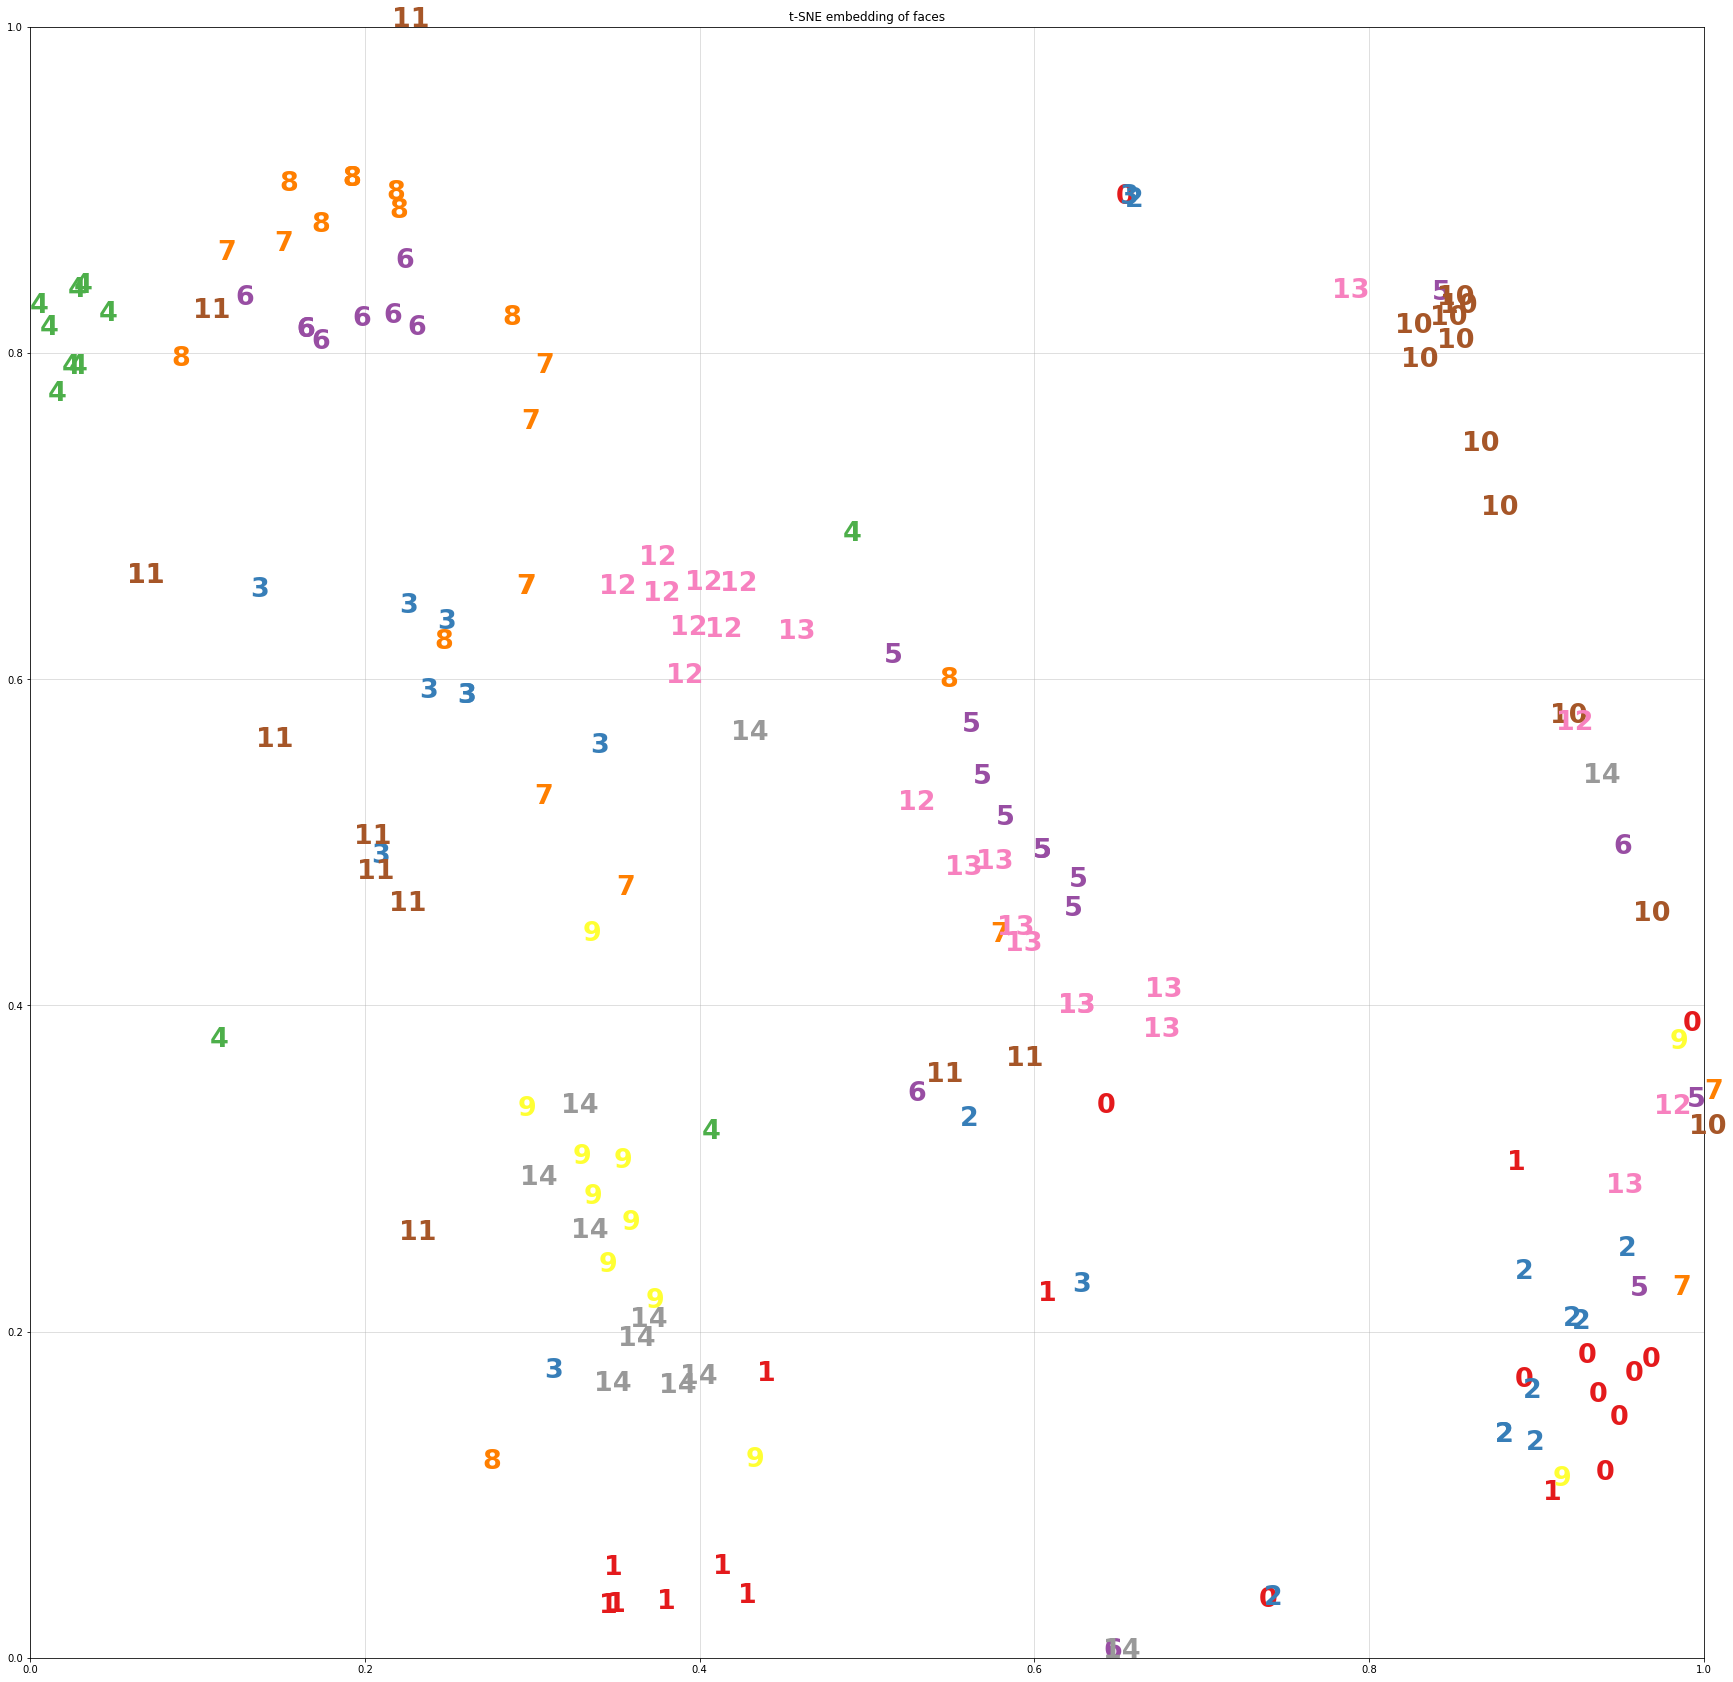

In [66]:
fig = plot_embedding(reduced, labels.detach().numpy(),'t-SNE embedding of faces')
plt.show(fig)
# plt.savefig("t-SNE_visualization_of_test_embeddings.png")

In [71]:
distances = triplet_loss._pairwise_distances(embeddings)
distances.shape

torch.Size([165, 165])

In [67]:
def pairs_mask(labels):
    induces_not_equal = torch.eye(labels.shape[0]).bool().logical_not()
    return induces_not_equal
mask = pairs_mask(labels)

In [68]:
Psame = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))[mask]
Psame.shape, Psame.sum()

(torch.Size([27060]), tensor(1650))

In [69]:
Pdiff = Psame.logical_not()
Pdiff.shape, Pdiff.sum()

(torch.Size([27060]), tensor(25410))

In [72]:
dists = distances[mask]
dists.shape, dists.max(), dists.mean(), dists.min()

(torch.Size([27060]),
 tensor(1.4142, grad_fn=<MaxBackward1>),
 tensor(0.3148, grad_fn=<MeanBackward0>),
 tensor(0., grad_fn=<MinBackward1>))

In [75]:
val, far, precision, accuracy = calculate_metrics(0.51, dists.detach().numpy(), Psame.detach().numpy())

In [76]:
print(f"True accept rate = {val}")
print(f"False Accept Rate = {far}")
print(f"Precision = {precision}")
print(f"Accuracy = {accuracy}")

True accept rate = 0.8375757575757575
False Accept Rate = 0.7933884297520661
Precision = 0.06415374617027203
Accuracy = 0.2450849963045085


400it [00:00, 3598.16it/s]


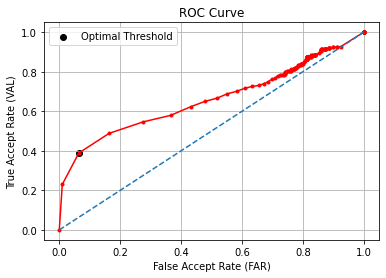

In [77]:
best_threshold, tar, far, precision, accuracy = evaluate(dists.detach().numpy(), Psame.detach().numpy(), roc_curve=True)

In [78]:
print("Best Threshold: {}\nTrue Acceptance: {:.3f}\nFalse Acceptance: {:.3f}\nPrecision: {:.3f}\nAccuracy: {:.3f}".format(best_threshold, tar, far, precision, accuracy ))

Best Threshold: 0.02
True Acceptance: 0.389
False Acceptance: 0.064
Precision: 0.282
Accuracy: 0.902


distance tensor(1.4846, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

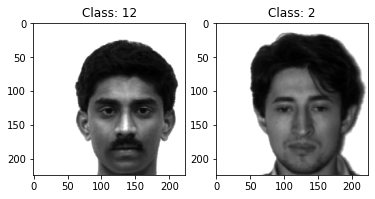

distance tensor(1.2999, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

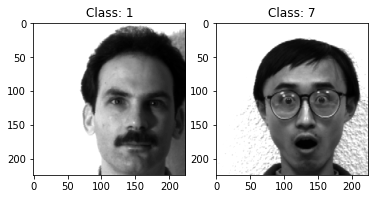

distance tensor(1.0217, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

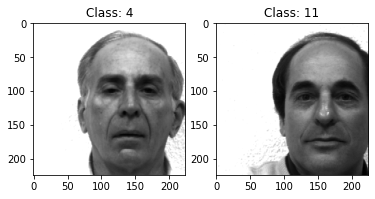

distance tensor(1.0217, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

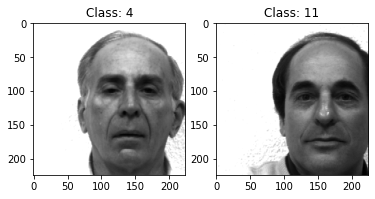

distance tensor(1.7954, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

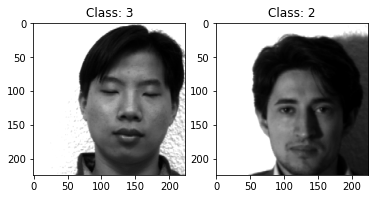

distance tensor(0.8636, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

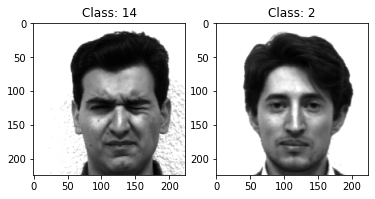

distance tensor(1.4574, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

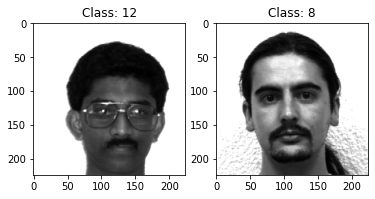

distance tensor(1.0928, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

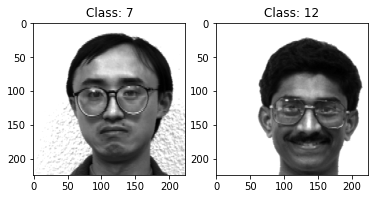

distance tensor(1.4004, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

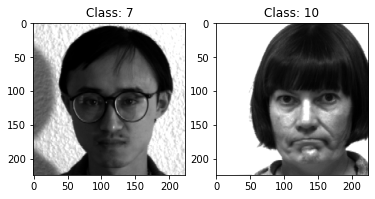

distance tensor(1.3135, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

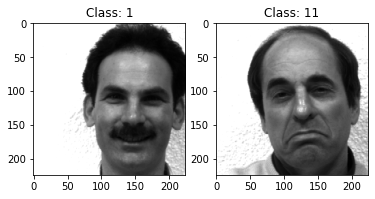

distance tensor(1.3605, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

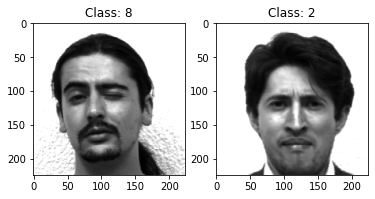

distance tensor(1.3530, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

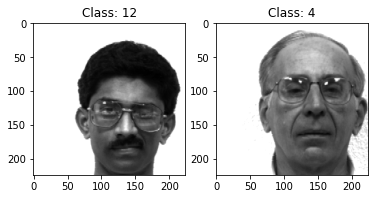

distance tensor(0.8715, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

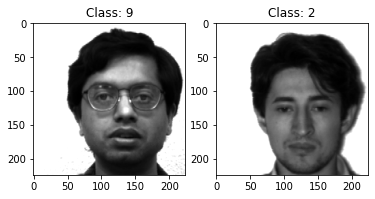

distance tensor(1.3586, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

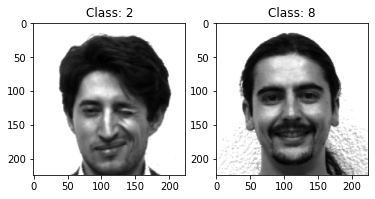

distance tensor(1.0815, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

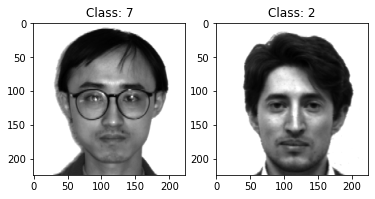

distance tensor(0.9348, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

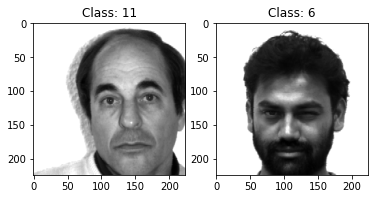

distance tensor(1.3683, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

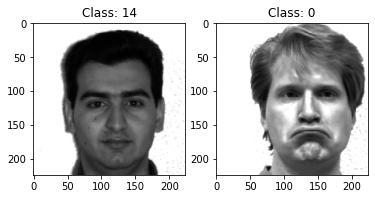

distance tensor(1.1895, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

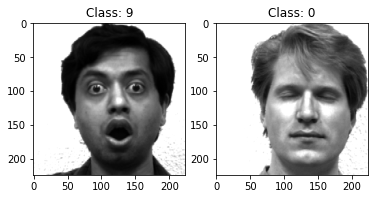

distance tensor(1.4886, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

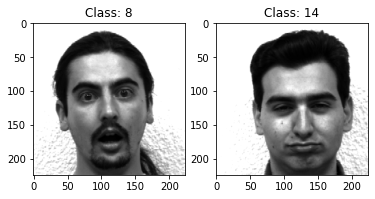

distance tensor(1.5852, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

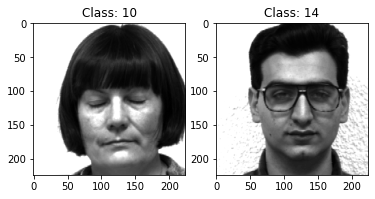

distance tensor(1.7691, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

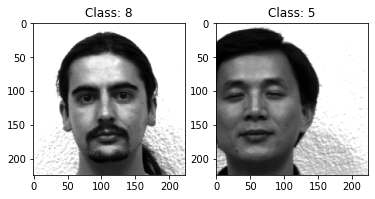

distance tensor(1.2074, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

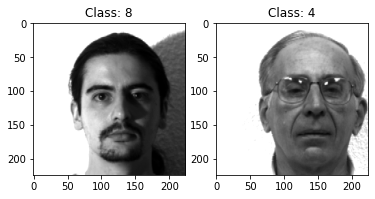

distance tensor(1.6135, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

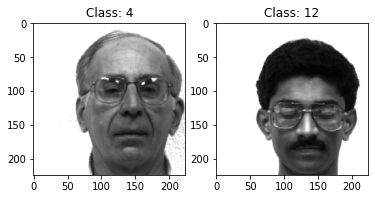

distance tensor(1.7800, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

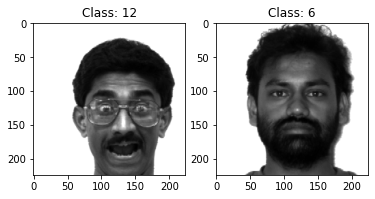

distance tensor(1.3428, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

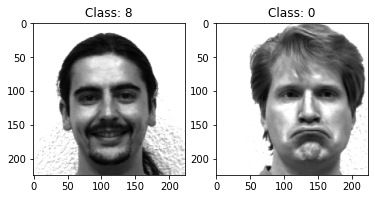

distance tensor(1.2143, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

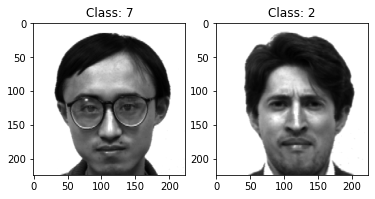

distance tensor(1.6087, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

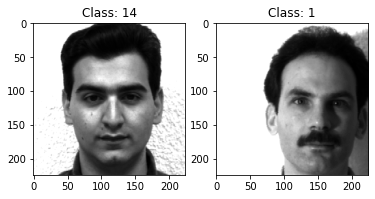

distance tensor(1.5030, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

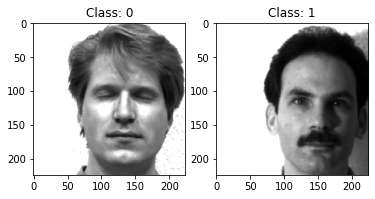

distance tensor(1.4915, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

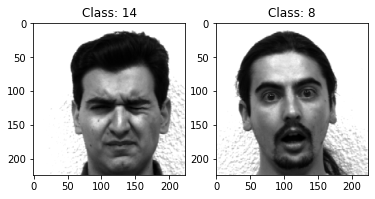

distance tensor(1.2256, grad_fn=<PowBackward0>)


<Figure size 432x288 with 0 Axes>

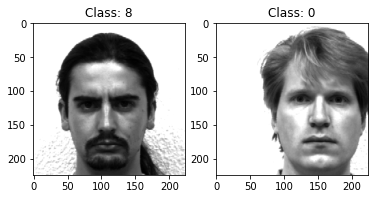

In [ ]:
for idx in np.random.randint(0,7267, size=30):
    plt.figure()
    _,(i1,i2) = plt.subplots(1,2)
    img1 = test[ false_accept_idxs[idx][0].item() ]
    img2 = test[ false_accept_idxs[idx][1].item() ]

    i1.imshow(img1[0].squeeze(), cmap='gray')
    i1.title.set_text(f'Class: {img1[1]}')
    i2.imshow(img2[0].squeeze(), cmap='gray')
    i2.title.set_text(f'Class: {img2[1]}')

    embd = resnet18(torch.stack([img1[0],img2[0]]).to(device)).to('cpu')
    print('distance', dist(embd[0], embd[1]))
    plt.show()

Text(0.5, 1.0, '1.41117262840271')

<Figure size 432x288 with 0 Axes>

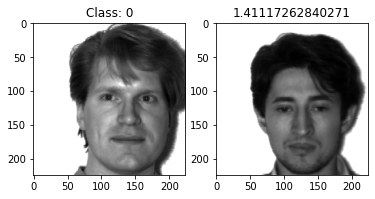

In [ ]:
plt.figure()
_,(i1,i2) = plt.subplots(1,2)

img1 = test[0]#[0]
img2 = test[22]#[0]

i1.imshow(img1[0].squeeze(), cmap='gray')
i1.title.set_text(f'Class: {img1[1]}')
i2.imshow(img2[0].squeeze(), cmap='gray')
i2.title.set_text(f'Class: {img2[1]}')

embd = resnet18(torch.stack([img1[0],img2[0]]).to(device)).to('cpu')
dist(embd[0], embd[1])
plt.title(str(dist(embd[0], embd[1]).item()))

In [79]:
wandb.finish()

# Sweeps

In [12]:
import wandb

### Define Sweep

In [13]:
sweep_config = {
    'method': 'random' # grid, random, bayes
    }

In [14]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

In [15]:
parameter_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
    },
    'fc_layer_size': {
        'values': [64, 128, 256]
    },
    'learning_rate': {
        'values': [0.01, 0.001, 0.0002, 0.0001]
    },
    'batch_size': {
        'values': [10,40,100]
    },
    'epochs': {
        'values': [10,50,100,200]
    }
}
sweep_config['parameters'] = parameter_dict

In [16]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [10, 40, 100]},
                'epochs': {'values': [10, 50, 100, 200]},
                'fc_layer_size': {'values': [64, 128, 256]},
                'learning_rate': {'values': [0.01, 0.001, 0.0002, 0.0001]},
                'optimizer': {'values': ['adam', 'sgd']}}}


### Initialize Sweep

In [17]:
sweep_id = wandb.sweep(sweep_config, project='Face-Unlock')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: auyhg321
Sweep URL: https://wandb.ai/abd1/Face-Unlock/sweeps/auyhg321


In [18]:
def pairs_mask(labels):
    induces_not_equal = torch.eye(labels.shape[0]).bool().logical_not()
    return induces_not_equal

In [19]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'batch_size': 40,
        'epochs': 10,
        'fc_layer_size': 128,
        'learning_rate': 0.0001,
        'optimizer': 'adam',
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # define model
    network = ResNet()
    network.fc = nn.Sequential(
        nn.Linear(in_features=512*1, out_features = config.fc_layer_size),
        nn.ReLU(inplace=True)
    )
    network.to(device)
    # train loader 
    loader = DataLoader(train_data, batch_size = config.batch_size, shuffle=True)
    # optimizer
    if config.optimizer=='sgd':
        optimizer = optim.SGD(network.parameters(), lr=config.learning_rate, momentum=0.9)
    elif config.optimizer=='adam':
        optimizer = optim.Adam(network.parameters(), lr=config.learning_rate)

    network.train()
    network = network.to(device)
    for epoch in range(config.epochs):
        epoch_loss = 0
        for images, labels in loader:
            optimizer.zero_grad()
            embds = network(images.to(device)).to('cpu')
            loss, fpt = triplet_loss.batch_all_triplet_loss(labels, embds, margin=1)
            epoch_loss += loss.item()
            wandb.log({"loss": loss.item(), "fraction_of_positive_triplets": fpt}, commit=False)
            loss.backward()
            optimizer.step()

            mask = pairs_mask(labels)
            Psame = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))[mask]
            dists = triplet_loss._pairwise_distances(embds)[mask]
            best_threshold, tar, far, precision, accuracy = evaluate(dists.detach().numpy(), Psame.detach().numpy())
            wandb.log({"best_threshold":best_threshold,
                      "True Acceptance Rate": tar,
                      "False Acceptace Rate": far,
                      "Accuracy":accuracy})

        wandb.log({"epoch_loss": epoch_loss / config.batch_size})


### Run sweep Agent

In [ ]:
wandb.agent(sweep_id, train, count=10)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: ql1f899v with config:
wandb: 	batch_size: 100
wandb: 	epochs: 10
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


400it [00:00, 6742.14it/s]
400it [00:00, 6410.98it/s]
400it [00:00, 6066.63it/s]
400it [00:00, 7118.82it/s]
400it [00:00, 6422.86it/s]
400it [00:00, 7338.25it/s]
400it [00:00, 7782.07it/s]
400it [00:00, 6453.30it/s]
400it [00:00, 6958.53it/s]
400it [00:00, 6731.57it/s]
400it [00:00, 6467.93it/s]
400it [00:00, 6678.38it/s]
400it [00:00, 8041.27it/s]
400it [00:00, 5924.95it/s]
400it [00:00, 8550.21it/s]
400it [00:00, 7918.75it/s]
400it [00:00, 6725.04it/s]
400it [00:00, 6125.84it/s]
400it [00:00, 7437.60it/s]
400it [00:00, 8121.45it/s]
400it [00:00, 6970.99it/s]
400it [00:00, 7492.04it/s]
400it [00:00, 6676.54it/s]
400it [00:00, 7312.31it/s]
400it [00:00, 6413.70it/s]
400it [00:00, 6309.69it/s]
400it [00:00, 6558.98it/s]
400it [00:00, 6472.79it/s]
400it [00:00, 6463.34it/s]
400it [00:00, 6148.25it/s]
400it [00:00, 6996.77it/s]
400it [00:00, 7780.63it/s]
400it [00:00, 6261.93it/s]
400it [00:00, 6528.68it/s]
400it [00:00, 7929.90it/s]
400it [00:00, 6786.05it/s]
400it [00:00, 7453.53it/s]
4

wandb: Agent Starting Run: 8g3d5soa with config:
wandb: 	batch_size: 10
wandb: 	epochs: 100
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


400it [00:00, 15255.34it/s]
400it [00:00, 16121.40it/s]
400it [00:00, 18292.37it/s]
400it [00:00, 18399.30it/s]
400it [00:00, 15449.20it/s]
400it [00:00, 14047.62it/s]
400it [00:00, 18197.14it/s]
400it [00:00, 19153.82it/s]
400it [00:00, 15439.11it/s]
400it [00:00, 15040.90it/s]
400it [00:00, 19661.80it/s]
400it [00:00, 14752.83it/s]
400it [00:00, 15069.40it/s]
400it [00:00, 12311.93it/s]
400it [00:00, 15114.34it/s]
400it [00:00, 16059.98it/s]
400it [00:00, 11597.37it/s]
400it [00:00, 14877.77it/s]
400it [00:00, 14902.75it/s]
400it [00:00, 17482.64it/s]
400it [00:00, 16421.69it/s]
400it [00:00, 20445.81it/s]
400it [00:00, 15156.12it/s]
400it [00:00, 18766.04it/s]
400it [00:00, 17746.91it/s]
400it [00:00, 14233.66it/s]
400it [00:00, 12847.64it/s]
400it [00:00, 19266.22it/s]
400it [00:00, 13972.86it/s]
400it [00:00, 15511.91it/s]
400it [00:00, 10729.52it/s]
400it [00:00, 17507.45it/s]
400it [00:00, 19877.75it/s]
400it [00:00, 17141.30it/s]
400it [00:00, 14235.47it/s]
400it [00:00, 14757.

wandb: Agent Starting Run: mj7alv37 with config:
wandb: 	batch_size: 100
wandb: 	epochs: 200
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0002
wandb: 	optimizer: sgd


400it [00:00, 7695.48it/s]
400it [00:00, 6583.33it/s]
400it [00:00, 7651.92it/s]
400it [00:00, 6426.57it/s]
400it [00:00, 7477.64it/s]
400it [00:00, 7602.68it/s]
400it [00:00, 7472.18it/s]
400it [00:00, 7971.88it/s]
400it [00:00, 6257.12it/s]
400it [00:00, 6071.77it/s]
400it [00:00, 6522.74it/s]
400it [00:00, 6006.60it/s]
400it [00:00, 5896.13it/s]
400it [00:00, 5770.52it/s]
400it [00:00, 5666.54it/s]
400it [00:00, 5693.62it/s]
400it [00:00, 7284.65it/s]
400it [00:00, 6383.30it/s]
400it [00:00, 6269.86it/s]
400it [00:00, 6684.90it/s]
400it [00:00, 4977.31it/s]
400it [00:00, 6160.14it/s]
400it [00:00, 6482.95it/s]
400it [00:00, 6340.74it/s]
400it [00:00, 7242.33it/s]
400it [00:00, 6877.82it/s]
400it [00:00, 6250.62it/s]
400it [00:00, 5712.33it/s]
400it [00:00, 7949.29it/s]
400it [00:00, 6646.05it/s]
400it [00:00, 5896.59it/s]
400it [00:00, 7354.11it/s]
400it [00:00, 5964.51it/s]
400it [00:00, 7295.20it/s]
400it [00:00, 5538.84it/s]
400it [00:00, 7524.12it/s]
400it [00:00, 6385.02it/s]
4